In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

In [2]:
fullset = pd.read_csv('C:/Users/psh/Desktop/fullset.csv', encoding = 'cp949')

In [3]:
fullset = fullset.drop(['Unnamed: 0'], axis=1)

In [4]:
fullset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13519862 entries, 0 to 13519861
Data columns (total 66 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   loan_limit                   float64
 1   loan_rate                    float64
 2   credit_score                 float64
 3   app_count                    float64
 4   birth_year                   float64
 5   employed_time                float64
 6   credit_score_em_mean         float64
 7   credit_score_em_std          float64
 8   credit_score_hm_mean         float64
 9   credit_score_hm_std          float64
 10  credit_score_rh_mean         float64
 11  credit_score_rh_std          float64
 12  credit_score_in_mean         float64
 13  desired_amount_pp_mean       float64
 14  desired_amount_pp_std        float64
 15  yearly_income_in_mean        float64
 16  yearly_income_in_std         float64
 17  yearly_income_em_mean        float64
 18  yearly_income_em_std         float64
 19

In [22]:
df_train = fullset[(fullset['Month']== 3)|(fullset['Month']== 4)] 
df_vali = fullset[fullset['Month']== 5] 
df_test = fullset[fullset['Month']== 6] 

In [23]:
df_train = df_train.drop(['Month'],axis=1)

In [24]:
df_vali = df_vali.drop(['Month'],axis=1)

In [25]:
df_test = df_test.drop(['Month'],axis=1)

In [26]:
df_train.isnull().sum()

loan_limit        0
loan_rate         0
credit_score      0
app_count         0
birth_year        0
                 ..
loan_group_3      0
loan_group_4      0
KCB_rank          0
income_ranking    0
is_applied        0
Length: 65, dtype: int64

In [27]:
df_train_x = df_train.drop(['is_applied'],axis=1)
df_train_y = df_train[['is_applied']]

In [28]:
df_vali_x  = df_vali.drop(['is_applied'],axis=1)
df_vali_y  = df_vali[['is_applied']]

In [29]:
df_test_x  = df_test.drop(['is_applied'],axis=1)
df_test_y  = df_test[['is_applied']]

# 샘플링 전 모델링(xgboost와 logistic을 이용해 샘플링 기법 선정)

## 원데이터

In [43]:
#성능평가 
from sklearn.metrics import confusion_matrix ,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
def get_clf_eval(y_test,pred=None,pred_prova=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_prova)
    print('오차행렬')
    print(confusion)
    print('정확도 :{0:4f}, 정밀도 :{1:4f}, 재현율 :{2:4f}, f1-score :{3:4f}, AUC :{4:4f}'
          .format(accuracy, precision, recall, f1, roc_auc))

In [44]:
#파라미터 튜닝용 그리드 서치
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [46]:
logreg = LogisticRegression()
logreg.fit(df_train_x, df_train_y)
pred = logreg.predict(df_vali_x)

In [47]:
pred_proba = logreg.predict_proba(df_vali_x)[:,1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3281576   11952]
 [ 178932   13369]]
정확도 :0.945240, 정밀도 :0.527981, 재현율 :0.069521, f1-score :0.122864, AUC :0.870928


In [54]:
xgb_clf = XGBClassifier()
xgb_clf.fit(df_train_x, df_train_y)
pred = xgb_clf.predict(df_vali_x)
pred_proba = xgb_clf.predict_proba(df_vali_x)[:, 1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3348338   27858]
 [ 163142   37979]]
정확도 :0.946608, 정밀도 :0.576864, 재현율 :0.188837, f1-score :0.284532, AUC :0.914780


## random over sampling

In [48]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [49]:
oversample = RandomOverSampler(sampling_strategy = 0.3, random_state = 42)
x_train_over, y_train_over = oversample.fit_resample(df_train_x, df_train_y)
print("오버샘플링 이전", df_train_y['is_applied'].value_counts())
print("오버샘플링 이후", y_train_over['is_applied'].value_counts())

오버샘플링 이전 0.0    6520566
1.0     356424
Name: is_applied, dtype: int64
오버샘플링 이후 0.0    6520566
1.0    1956169
Name: is_applied, dtype: int64


In [50]:
logreg = LogisticRegression()
logreg.fit(x_train_over, y_train_over)
pred = logreg.predict(df_vali_x)

In [51]:
pred_proba = logreg.predict_proba(df_vali_x)[:,1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3036166  257362]
 [  88053  104248]]
정확도 :0.900909, 정밀도 :0.288288, 재현율 :0.542108, f1-score :0.376407, AUC :0.871226


In [54]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train_over, y_train_over)
pred = xgb_clf.predict(df_vali_x)
pred_proba = xgb_clf.predict_proba(df_vali_x)[:, 1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3123215  252981]
 [  71147  129974]]
정확도 :0.909394, 정밀도 :0.339398, 재현율 :0.646248, f1-score :0.445059, AUC :0.914874


## SMOTE

In [52]:
smote = SMOTE(sampling_strategy = 0.3, random_state = 42)
x_train_smote, y_train_smote = oversample.fit_resample(df_train_x, df_train_y)
print("오버샘플링 이전", df_train_y['is_applied'].value_counts())
print("오버샘플링 이후", y_train_smote['is_applied'].value_counts())

오버샘플링 이전 0.0    6520566
1.0     356424
Name: is_applied, dtype: int64
오버샘플링 이후 0.0    6520566
1.0    1956169
Name: is_applied, dtype: int64


In [53]:
logreg = LogisticRegression()
logreg.fit(x_train_smote, y_train_smote)
pred = logreg.predict(df_vali_x)

In [54]:
pred_proba = logreg.predict_proba(df_vali_x)[:,1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3036166  257362]
 [  88053  104248]]
정확도 :0.900909, 정밀도 :0.288288, 재현율 :0.542108, f1-score :0.376407, AUC :0.871226


In [54]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train_smote, y_train_smote)
pred = xgb_clf.predict(df_vali_x)
pred_proba = xgb_clf.predict_proba(df_vali_x)[:, 1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3123215  252981]
 [  71147  129974]]
정확도 :0.909394, 정밀도 :0.339398, 재현율 :0.646248, f1-score :0.445059, AUC :0.914874


## ADASYN

In [55]:
adasyn = ADASYN(sampling_strategy = 0.3, random_state = 42)
x_train_ad, y_train_ad = oversample.fit_resample(df_train_x, df_train_y)
print("오버샘플링 이전", df_train_y['is_applied'].value_counts())
print("오버샘플링 이후", y_train_ad['is_applied'].value_counts())

오버샘플링 이전 0.0    6520566
1.0     356424
Name: is_applied, dtype: int64
오버샘플링 이후 0.0    6520566
1.0    1956169
Name: is_applied, dtype: int64


In [56]:
logreg = LogisticRegression()
logreg.fit(x_train_ad, y_train_ad)
pred = logreg.predict(df_vali_x)

In [57]:
pred_proba = logreg.predict_proba(df_vali_x)[:,1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3036166  257362]
 [  88053  104248]]
정확도 :0.900909, 정밀도 :0.288288, 재현율 :0.542108, f1-score :0.376407, AUC :0.871226


In [77]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train_ad, y_train_ad)
pred = xgb_clf.predict(df_vali_x)
pred_proba = xgb_clf.predict_proba(df_vali_x)[:, 1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3348107   28089]
 [ 166034   35087]]
정확도 :0.945735, 정밀도 :0.555385, 재현율 :0.174457, f1-score :0.265512, AUC :0.909012


### Sampling기법 RandomOverSampling 선정

# Random Over Sampling 이후 사용 모델

## Logistic 회귀

In [19]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train_over, y_train_over)
xgb_clfpred = xgb_clf.predict(df_vali_x)
xgb_clfpred_proba = xgb_clf.predict_proba(df_vali_x)[:, 1]
get_clf_eval(df_vali_y, xgb_clfpred, xgb_clfpred_proba)

오차행렬
[[3123215  252981]
 [  71147  129974]]
정확도 :0.909394, 정밀도 :0.339398, 재현율 :0.646248, f1-score :0.445059, AUC :0.914874


## XGBoost

In [19]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train_over, y_train_over)
xgb_clfpred = xgb_clf.predict(df_vali_x)
xgb_clfpred_proba = xgb_clf.predict_proba(df_vali_x)[:, 1]
get_clf_eval(df_vali_y, xgb_clfpred, xgb_clfpred_proba)

오차행렬
[[3123215  252981]
 [  71147  129974]]
정확도 :0.909394, 정밀도 :0.339398, 재현율 :0.646248, f1-score :0.445059, AUC :0.914874


## LGBM

In [20]:
lgbm = LGBMClassifier()
lgbm.fit(x_train_over, y_train_over)
lgbmpred = lgbm.predict(df_vali_x)
lgbmpred_proba = lgbm.predict_proba(df_vali_x)[:, 1]
get_clf_eval(df_vali_y, lgbmpred, lgbmpred_proba)

오차행렬
[[3126411  249785]
 [  73535  127586]]
정확도 :0.909619, 정밀도 :0.338092, 재현율 :0.634374, f1-score :0.441099, AUC :0.912124


## ADABoost

In [21]:
ada = AdaBoostClassifier()
ada.fit(x_train_over, y_train_over)
adapred = ada.predict(df_vali_x)
adapred_proba = ada.predict_proba(df_vali_x)[:, 1]
get_clf_eval(df_vali_y, adapred, adapred_proba)

오차행렬
[[3114577  261619]
 [  89407  111714]]
정확도 :0.901875, 정밀도 :0.299234, 재현율 :0.555457, f1-score :0.388940, AUC :0.882081


## GBM

In [22]:
gbm = GradientBoostingClassifier()
gbm.fit(x_train_over, y_train_over)
gbmpred = gbm.predict(df_vali_x)
gbmpred_proba = gbm.predict_proba(df_vali_x)[:, 1]
get_clf_eval(df_vali_y, gbmpred, gbmpred_proba)

오차행렬
[[3166072  210124]
 [  89228  111893]]
정확도 :0.916319, 정밀도 :0.347475, 재현율 :0.556347, f1-score :0.427776, AUC :0.899694


# DNN

In [19]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.callbacks import Callback,ModelCheckpoint
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

In [20]:
#f1-score 출력
def get_f1_1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [21]:
#데이터 어레이로 만들기
x_train_over_1 = np.array(x_train_over)
y_train_over_1 = np.array(y_train_over)
df_vali_x_1 = np.array(df_vali_x)
df_vali_y_1 = np.array(df_vali_y)

In [26]:
model = Sequential() # Sequeatial Model


model.add(Dense(16,input_dim=63))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[get_f1_1, 'accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                1024      
                                                                 
 dense_7 (Dense)             (None, 4)                 68        
                                                                 
 dense_8 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,097
Trainable params: 1,097
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(x_train_over, y_train_over,
                    epochs=10, batch_size=34, validation_data = (df_vali_x_1,df_vali_y_1))

Epoch 1/10
236211/236211 [==============================] - 245s 1ms/step - loss: 0.3453 - get_f1: 0.5998 - accuracy: 0.8409 - val_loss: 0.2292 - val_get_f1: 0.2903 - val_accuracy: 0.9013
Epoch 2/10
236211/236211 [==============================] - 241s 1ms/step - loss: 0.3419 - get_f1: 0.6090 - accuracy: 0.8443 - val_loss: 0.2363 - val_get_f1: 0.3013 - val_accuracy: 0.9015
Epoch 3/10
236211/236211 [==============================] - 238s 1ms/step - loss: 0.3394 - get_f1: 0.6160 - accuracy: 0.8467 - val_loss: 0.2353 - val_get_f1: 0.3053 - val_accuracy: 0.9001
Epoch 4/10
236211/236211 [==============================] - 244s 1ms/step - loss: 0.3389 - get_f1: 0.6170 - accuracy: 0.8469 - val_loss: 0.2492 - val_get_f1: 0.3044 - val_accuracy: 0.8941
Epoch 5/10
236211/236211 [==============================] - 242s 1ms/step - loss: 0.3387 - get_f1: 0.6178 - accuracy: 0.8472 - val_loss: 0.2411 - val_get_f1: 0.3032 - val_accuracy: 0.8983
Epoch 6/10
236211/236211 [==============================] - 

### 최종 사용 모델 DNN제거

# 하이퍼 파라미터 튜닝

## Logistic회귀

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [27]:
clf = LogisticRegression()
params = {
        'C':[0.01,0.02,0.5,1],
        'max_iter':[50,100,150]
}
grid_cv = GridSearchCV(clf, param_grid = params, cv=2, scoring='f1', verbose=1)
grid_cv.fit(x_train_over,y_train_over)
print('best parameters: ',grid_cv.best_params_)
print('best_score: ',grid_cv.best_score_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
best parameters:  {'C': 1, 'max_iter': 50}
best_score:  0.5803509098578514


In [28]:
clf = LogisticRegression(C=1,max_iter=50)
clf.fit(x_train_over,y_train_over)
pred = clf.predict(df_vali_x)

In [29]:
pred_proba = clf.predict_proba(df_vali_x)[:,1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3122685  253511]
 [  93946  107175]]
정확도 :0.902872, 정밀도 :0.297142, 재현율 :0.532888, f1-score :0.381537, AUC :0.873555


In [30]:
clf = LogisticRegression()
params = {
        'C':(1,5),
        'max_iter':(100,150)
}
grid_cv = GridSearchCV(clf, param_grid = params, cv=2, scoring='f1', verbose=1)
grid_cv.fit(x_train_over,y_train_over)
print('best parameters: ',grid_cv.best_params_)
print('best_score: ',grid_cv.best_score_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
best parameters:  {'C': 5, 'max_iter': 150}
best_score:  0.5800472729623203


In [31]:
clf = LogisticRegression()
params = {
        'C':(2.5,5,10),
        'max_iter':(125,150,200)
}
grid_cv = GridSearchCV(clf, param_grid = params, cv=2, scoring='f1', verbose=1)
grid_cv.fit(x_train_over,y_train_over)
print('best parameters: ',grid_cv.best_params_)
print('best_score: ',grid_cv.best_score_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
best parameters:  {'C': 2.5, 'max_iter': 150}
best_score:  0.5800766414358016


In [32]:
clf = LogisticRegression(C=2.5,max_iter=150)
clf.fit(x_train_over,y_train_over)
pred = clf.predict(df_vali_x)

In [33]:
pred_proba = clf.predict_proba(df_vali_x)[:,1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3124824  251372]
 [  94378  106743]]
정확도 :0.903349, 정밀도 :0.298069, 재현율 :0.530740, f1-score :0.381746, AUC :0.873673


In [34]:
clf = LogisticRegression()
params = {
        'C':(2,2.5,3),
        'max_iter':(130,150,170)
}
grid_cv = GridSearchCV(clf, param_grid = params, cv=2, scoring='f1', verbose=1)
grid_cv.fit(x_train_over,y_train_over)
print('best parameters: ',grid_cv.best_params_)
print('best_score: ',grid_cv.best_score_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
best parameters:  {'C': 2.5, 'max_iter': 150}
best_score:  0.5800766414358016


In [35]:
clf = LogisticRegression()
params = {
        'C':(2.25,2.5,2.75),
        'max_iter':(145,150,155)
}
grid_cv = GridSearchCV(clf, param_grid = params, cv=2, scoring='f1', verbose=1)
grid_cv.fit(x_train_over,y_train_over)
print('best parameters: ',grid_cv.best_params_)
print('best_score: ',grid_cv.best_score_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
best parameters:  {'C': 2.5, 'max_iter': 150}
best_score:  0.5800766414358016


In [36]:
clf = LogisticRegression()
params = {
        'C':(2.4,2.5,2.6),
        'max_iter':(148,150,152)
}
grid_cv = GridSearchCV(clf, param_grid = params, cv=2, scoring='f1', verbose=1)
grid_cv.fit(x_train_over,y_train_over)
print('best parameters: ',grid_cv.best_params_)
print('best_score: ',grid_cv.best_score_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
best parameters:  {'C': 2.6, 'max_iter': 148}
best_score:  0.5800887435580614


In [37]:
clf = LogisticRegression(C=2.6,max_iter=148)
clf.fit(x_train_over,y_train_over)
pred = clf.predict(df_vali_x)

In [38]:
pred_proba = clf.predict_proba(df_vali_x)[:,1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3124851  251345]
 [  94394  106727]]
정확도 :0.903352, 정밀도 :0.298060, 재현율 :0.530661, f1-score :0.381718, AUC :0.873671


In [39]:
clf = LogisticRegression(C=2.55,max_iter=149)
clf.fit(x_train_over,y_train_over)
pred = clf.predict(df_vali_x)

In [40]:
pred_proba = clf.predict_proba(df_vali_x)[:,1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3124666  251530]
 [  94378  106743]]
정확도 :0.903305, 정밀도 :0.297938, 재현율 :0.530740, f1-score :0.381638, AUC :0.873669


최종 파라미터 {'C': 2.5, 'max_iter': 150}

## XGBoost

In [20]:
pbounds = {'max_depth': (10, 20),
          'learning_rate': (0.01, 0.5),
          'min_child_weight': (0.01,1000),
          'subsample': (0.5, 1),
          'colsample_bytree': (0.2, 1)}

In [21]:
n_folds=4
d_train = xgb.DMatrix(x_train_over, y_train_over)
d_val = xgb.DMatrix(df_vali_x,df_vali_y)

In [22]:
d_train

In [24]:
def xgb_f1_score(y_hat, data):
    y_true = data.get_label().astype(int)
    y_hat = np.round(y_hat).astype(int) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat)


In [25]:
def xgb_cv(max_depth, learning_rate, min_child_weight, subsample, colsample_bytree):
    params = {'nrounds' : 2000,
             'early_stopping_rounds': 20,
             'n_jobs':-1
             }
    params['max_depth']= int(round(max_depth))
    params['learning_rate'] = learning_rate
    params['min_child_weight'] = min_child_weight
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample_bytree
        
    xgbcv = xgb.cv(params, d_train, nfold=n_folds, seed=42, stratified=True, verbose_eval = 200, feval=xgb_f1_score)
    
    mean_f1 = xgbcv["test-f1-mean"].values[-1]
    
    return mean_f1


In [26]:
lgbB1 = BayesianOptimization(xgb_cv,pbounds,random_state=42,verbose=0)
init_round = 5
opt_round = 10
lgbB1.maximize(init_points=init_round, n_iter=opt_round)
print(lgbB1.max)

[04:50:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:50:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[04:50:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "e

[05:09:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:09:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "e

[05:28:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:28:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.43197+0.00005	train-f1:0.58365+0.00104	test-rmse:0.43225+0.00005	test-f1:0.58052+0.00132
[9]	train-rm

[05:48:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.40696+0.00010	train-f1:0.52959+0.00821	test-rmse:0.40709+0.00008	test-f1:0.52841+0.00825
[9]	train-rmse:0.31208+0.00016	train-f1:0.67129+0.00047	test-rmse:0.31349+0.00006	test-f1:0.66783+0.00039
[05:51:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually bein

In [27]:
params1 = {'colsample_bytree': 0.920424841774389,
          'learning_rate': 0.2842057203730153, 
          'max_depth': 16, 
          'min_child_weight': 366.3862980089001, 
          'subsample': 0.629757927803605}

In [28]:
a =  {'nrounds' : 5000,
      'early_stopping_rounds':30,
      'n_jobs':-1}

In [29]:
params1.update(a)

In [30]:
params1

{'colsample_bytree': 0.920424841774389,
 'learning_rate': 0.2842057203730153,
 'max_depth': 16,
 'min_child_weight': 366.3862980089001,
 'subsample': 0.629757927803605,
 'nrounds': 5000,
 'early_stopping_rounds': 30,
 'n_jobs': -1}

In [31]:
d_train = xgb.DMatrix(x_train_over, y_train_over)
d_val = xgb.DMatrix(df_vali_x,df_vali_y)

In [33]:
watch_list = [(d_val, 'eval'), (d_train, 'train')]
xgb2 = xgb.train(params1, d_train, evals = watch_list, feval=xgb_f1_score) #xgb train

[06:27:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stopping_rounds", "nrounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	eval-rmse:0.40467	eval-f1:0.41386	train-rmse:0.42032	train-f1:0.66682
[1]	eval-rmse:0.34417	eval-f1:0.42597	train-rmse:0.37227	train-f1:0.67383
[2]	eval-rmse:0.30640	eval-f1:0.43339	train-rmse:0.34388	train-f1:0.67849
[3]	eval-rmse:0.28304	eval-f1:0.43926	train-rmse:0.32554	train-f1:0.68611
[4]	eval-rmse:0.26930	eval-f1:0.44230	train-rmse:0.31434	train-f1:0.69267
[5]	eval-rmse:0.26105	eval-f1:0.44507	train-rmse:0.30725	train-f1:0.69791
[6]	eval-rmse:0.25650	eval-f1:0.44645	train-rmse:0.30270	train-f1:0.70231
[7]	eval-rmse:0.25389	eval-f1:0.44666	tra

In [18]:
from sklearn.metrics import confusion_matrix ,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [ ]:
def get_clf_eval(y_test,pred=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    print('오차행렬')
    print(confusion)
    print('정확도 :{0:4f}, 정밀도 :{1:4f}, 재현율 :{2:4f}, f1-score :{3:4f}'
          .format(accuracy, precision, recall, f1))

In [ ]:
watch_list = [(d_val, 'eval'), (d_train, 'train')]
xgb2 = xgb.train(params1, d_train, evals = watch_list, feval=xgb_f1_score) #xgb train

In [37]:
dtest = xgb.DMatrix(df_vali_x)
xgb_prob = xgb2.predict(dtest)
y_pred = np.around(xgb_prob).astype(int)
get_clf_eval(df_vali_y, y_pred)

오차행렬
[[3155508  220688]
 [  79349  121772]]
정확도 :0.916128, 정밀도 :0.355580, 재현율 :0.605466, f1-score :0.448036


## ADABoost

In [18]:
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier()

In [22]:
from sklearn.metrics import f1_score, make_scorer

In [28]:
from sklearn.model_selection import GridSearchCV
f1 = make_scorer(f1_score,pos_label=1)

params = {
    'n_estimators':[50,100, 200],
    'learning_rate':[0.01,0.05,0.1,0.2]
}
grid_cv = GridSearchCV(ab,param_grid=params, cv=2 ,scoring = f1,verbose=1)
grid_cv.fit(x_train_over,y_train_over)
print('최적의 파라미터 :',grid_cv.best_params_)
print('최고의 예측 정확도 :',grid_cv.best_score_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
최적의 파라미터 : {'learning_rate': 0.2, 'n_estimators': 200}
최고의 예측 정확도 : 0.5900851210544089


In [29]:
ab = AdaBoostClassifier(n_estimators=200, learning_rate=0.2)
ab.fit(x_train_over,y_train_over)
pred = ab.predict(df_vali_x)

In [30]:
pred_proba = ab.predict_proba(df_vali_x)[:,1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3159507  216689]
 [  97041  104080]]
정확도 :0.912300, 정밀도 :0.324470, 재현율 :0.517499, f1-score :0.398858, AUC :0.886133


최종 파라미터 n_estimators=200, learning_rate=0.2

## GBM

In [19]:
gb = GradientBoostingClassifier(n_estimators=300,learning_rate = 0.05)
gb.fit(x_train_over,y_train_over)
pred = gb.predict(df_vali_x)

In [20]:
pred_proba = gb.predict_proba(df_vali_x)[:,1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3163025  213171]
 [  86706  114415]]
정확도 :0.916173, 정밀도 :0.349267, 재현율 :0.568886, f1-score :0.432811, AUC :0.903652


In [21]:
gb = GradientBoostingClassifier(n_estimators=100,learning_rate = 0.15, max_depth=5)
gb.fit(x_train_over,y_train_over)
pred = gb.predict(df_vali_x)

In [22]:
pred_proba = gb.predict_proba(df_vali_x)[:,1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3138924  237272]
 [  75682  125439]]
정확도 :0.912517, 정밀도 :0.345837, 재현율 :0.623699, f1-score :0.444952, AUC :0.911940


In [23]:
gb = GradientBoostingClassifier()
gb.fit(x_train_over,y_train_over)
pred = gb.predict(df_vali_x)

In [24]:
pred_proba = gb.predict_proba(df_vali_x)[:,1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3166072  210124]
 [  89228  111893]]
정확도 :0.916319, 정밀도 :0.347475, 재현율 :0.556347, f1-score :0.427776, AUC :0.899694


In [25]:
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.15)
gb.fit(x_train_over,y_train_over)
pred = gb.predict(df_vali_x)

In [26]:
pred_proba = gb.predict_proba(df_vali_x)[:,1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3137104  239092]
 [  75947  125174]]
정확도 :0.911934, 정밀도 :0.343633, 재현율 :0.622382, f1-score :0.442791, AUC :0.911132


In [27]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.15,max_depth=3)
gb.fit(x_train_over,y_train_over)
pred = gb.predict(df_vali_x)

In [28]:
pred_proba = gb.predict_proba(df_vali_x)[:,1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3157160  219036]
 [  85091  116030]]
정확도 :0.914985, 정밀도 :0.346290, 재현율 :0.576916, f1-score :0.432797, AUC :0.903837


In [20]:
gb = GradientBoostingClassifier(n_estimators=200)
gb.fit(x_train_over,y_train_over)
pred = gb.predict(df_vali_x)

In [21]:
pred_proba = gb.predict_proba(df_vali_x)[:,1]
get_clf_eval(df_vali_y, pred, pred_proba)

오차행렬
[[3156115  220081]
 [  84144  116977]]
정확도 :0.914957, 정밀도 :0.347053, 재현율 :0.581625, f1-score :0.434714, AUC :0.905659


최종 파라미터 {n_estimators=100,learning_rate = 0.15, max_depth=5}

# Voting 앙상블(변수선택 진행 전)

## Soft Voting

In [36]:
from sklearn.ensemble import VotingClassifier

In [37]:
log_reg = LogisticRegression(C = 2.5, max_iter=150)
xgb_clf = XGBClassifier(colsample_bytree = 0.920424841774389,
          learning_rate = 0.2842057203730153, 
          max_depth = 16, 
          min_child_weight = 366.3862980089001, 
          subsample = 0.629757927803605)
lgbm = LGBMClassifier()
ada_1 = AdaBoostClassifier(n_estimators = 200, learning_rate = 0.2)
gbm = GradientBoostingClassifier(n_estimators=100,learning_rate = 0.15, max_depth=5)

vo_clf = VotingClassifier(estimators = [('LOG', log_reg), ('XGB', xgb_clf), ('LGBM', lgbm), ('ADA', ada_1), ('GBM', gbm)], voting = 'soft')
vo_clf.fit(x_train_over, y_train_over)
vopred = vo_clf.predict(df_vali_x)
vopred_proba = vo_clf.predict_proba(df_vali_x)[:, 1]
get_clf_eval(df_vali_y, vopred, vopred_proba)

오차행렬
[[3155441  220755]
 [  77557  123564]]
정확도 :0.916610, 정밀도 :0.358865, 재현율 :0.614376, f1-score :0.453080, AUC :0.914257


## Hard Voting

In [ ]:
log_reg = LogisticRegression(C = 2.5, max_iter=150)
xgb_clf = XGBClassifier(colsample_bytree = 0.920424841774389,
          learning_rate = 0.2842057203730153, 
          max_depth = 16, 
          min_child_weight = 366.3862980089001, 
          subsample = 0.629757927803605)
lgbm = LGBMClassifier()
ada_1 = AdaBoostClassifier(n_estimators = 200, learning_rate = 0.2)
gbm = GradientBoostingClassifier(n_estimators=100,learning_rate = 0.15, max_depth=5)

vo_clf = VotingClassifier(estimators = [('LOG', log_reg), ('XGB', xgb_clf), ('LGBM', lgbm), ('ADA', ada_1), ('GBM', gbm)], voting = 'hard')
vo_clf.fit(x_train_over, y_train_over)
vopred = vo_clf.predict(df_vali_x)

In [40]:
get_clf_eval(df_vali_y, vopred)

오차행렬
[[3152736  223460]
 [  78184  122937]]
정확도 :0.915679, 정밀도 :0.354902, 재현율 :0.611259, f1-score :0.449070


# 변수 중요도 파악

가장 성능이 좋은 xgboost모델을 기준으로 변수 선택을 진행했다.

<function matplotlib.pyplot.show(close=None, block=None)>

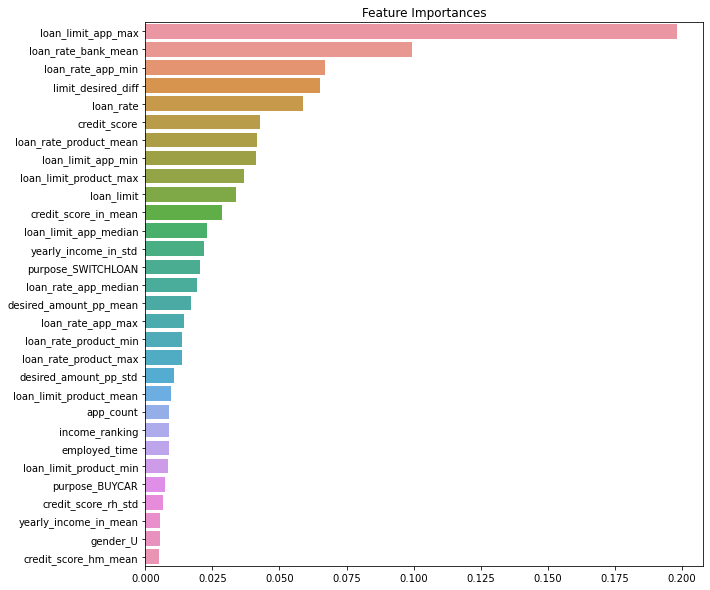

In [37]:
ftr_importances_values = xgb_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train_over.columns)
ftr_top10 = ftr_importances.sort_values(ascending = False)[:30]
plt.figure(figsize = (10,10))
plt.title("Feature Importances")
sns.barplot(x=ftr_top10, y=ftr_top10.index)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

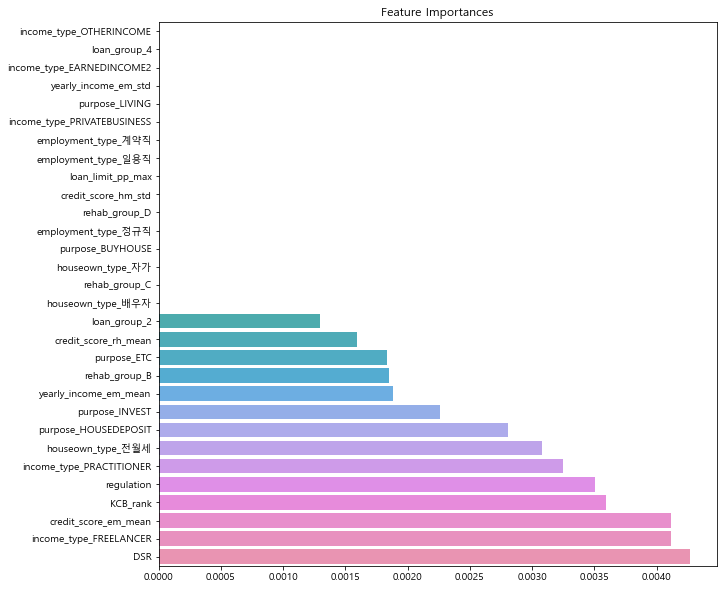

In [43]:
ftr_importances_values = xgb_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train_over.columns)
ftr_top10 = ftr_importances.sort_values(ascending = True)[:30]
plt.figure(figsize = (10,10))
plt.title("Feature Importances")
sns.barplot(x=ftr_top10, y=ftr_top10.index)
plt.show

In [48]:
fullset = fullset.drop(['income_type_OTHERINCOME', 'loan_group_4', 'income_type_EARNEDINCOME2', 'yearly_income_em_std', 
                        'purpose_LIVING', 'income_type_PRIVATEBUSINESS', 'employment_type_계약직', 'employment_type_일용직',
                        'loan_limit_pp_max', 'credit_score_hm_std', 'rehab_group_D', 'employment_type_정규직', 'purpose_BUYHOUSE',
                       'houseown_type_자가', 'rehab_group_C'], axis=1)

# 변수선택 이후 단일모델 성능

In [65]:
log_reg = LogisticRegression(C = 2.5, max_iter=150)
log_reg.fit(x_train_over, y_train_over)
log_regpred = log_reg.predict(df_vali_x)
log_regpred_proba = log_reg.predict_proba(df_vali_x)[:, 1]
get_clf_eval(df_vali_y, log_regpred, log_regpred_proba)

오차행렬
[[3125776  250420]
 [  94576  106545]]
정확도 :0.903560, 정밀도 :0.298475, 재현율 :0.529756, f1-score :0.381823, AUC :0.873427


In [66]:
xgb_clf = XGBClassifier(colsample_bytree = 0.920424841774389,
          learning_rate = 0.2842057203730153, 
          max_depth = 16, 
          min_child_weight = 366.3862980089001, 
          subsample = 0.629757927803605)
xgb_clf.fit(x_train_over, y_train_over)
xgb_clfpred = xgb_clf.predict(df_vali_x)
xgb_clfpred_proba = xgb_clf.predict_proba(df_vali_x)[:, 1]
get_clf_eval(df_vali_y, xgb_clfpred, xgb_clfpred_proba)

오차행렬
[[3132658  243538]
 [  72645  128476]]
정확도 :0.911614, 정밀도 :0.345353, 재현율 :0.638800, f1-score :0.448327, AUC :0.915927


In [67]:
lgbm = LGBMClassifier(colsample_bytree = 0.7, learning_rate = 0.5, max_depth = 15, subsample = 0.7)
lgbm.fit(x_train_over, y_train_over)
lgbmpred = lgbm.predict(df_vali_x)
lgbmpred_proba = lgbm.predict_proba(df_vali_x)[:, 1]
get_clf_eval(df_vali_y, lgbmpred, lgbmpred_proba)

오차행렬
[[3106711  269485]
 [  69799  131322]]
정확도 :0.905157, 정밀도 :0.327644, 재현율 :0.652950, f1-score :0.436338, AUC :0.912648


In [68]:
ada = AdaBoostClassifier(n_estimators = 200, learning_rate = 0.2)
ada.fit(x_train_over, y_train_over)
adapred = ada.predict(df_vali_x)
adapred_proba = ada.predict_proba(df_vali_x)[:, 1]
get_clf_eval(df_vali_y, adapred, adapred_proba)

오차행렬
[[3159507  216689]
 [  97041  104080]]
정확도 :0.912300, 정밀도 :0.324470, 재현율 :0.517499, f1-score :0.398858, AUC :0.886133


In [69]:
gbm = GradientBoostingClassifier(n_estimators=100,learning_rate = 0.15, max_depth=5)
gbm.fit(x_train_over, y_train_over)
gbmpred = gbm.predict(df_vali_x)
gbmpred_proba = gbm.predict_proba(df_vali_x)[:, 1]
get_clf_eval(df_vali_y, gbmpred, gbmpred_proba)

오차행렬
[[3138925  237271]
 [  75682  125439]]
정확도 :0.912517, 정밀도 :0.345838, 재현율 :0.623699, f1-score :0.444952, AUC :0.911940


# 변수선택 이후 SoftVoting

In [70]:
log_reg = LogisticRegression(C = 2.5, max_iter=150)
xgb_clf = XGBClassifier(colsample_bytree = 0.920424841774389,
          learning_rate = 0.2842057203730153, 
          max_depth = 16, 
          min_child_weight = 366.3862980089001, 
          subsample = 0.629757927803605)
lgbm = LGBMClassifier(colsample_bytree = 0.7, learning_rate = 0.5, max_depth = 15, subsample = 0.7)
ada_1 = AdaBoostClassifier(n_estimators = 200, learning_rate = 0.2)
gbm = GradientBoostingClassifier(n_estimators=100,learning_rate = 0.15, max_depth=5)

vo_clf = VotingClassifier(estimators = [('LOG', log_reg), ('XGB', xgb_clf), ('LGBM', lgbm), ('ADA', ada_1), ('GBM', gbm)], voting = 'soft')
vo_clf.fit(x_train_over, y_train_over)
vopred = vo_clf.predict(df_vali_x)
vopred_proba = vo_clf.predict_proba(df_vali_x)[:, 1]
get_clf_eval(df_vali_y, vopred, vopred_proba)

오차행렬
[[3152698  223498]
 [  76092  125029]]
정확도 :0.916253, 정밀도 :0.358735, 재현율 :0.621661, f1-score :0.454942, AUC :0.915492


In [ ]:
log_reg = LogisticRegression(C = 2.5, max_iter=150)
xgb_clf = XGBClassifier(colsample_bytree = 0.920424841774389,
          learning_rate = 0.2842057203730153, 
          max_depth = 16, 
          min_child_weight = 366.3862980089001, 
          subsample = 0.629757927803605)
lgbm = LGBMClassifier(colsample_bytree = 0.7, learning_rate = 0.5, max_depth = 15, subsample = 0.7)
ada_1 = AdaBoostClassifier(n_estimators = 200, learning_rate = 0.2)
gbm = GradientBoostingClassifier(n_estimators=100,learning_rate = 0.15, max_depth=5)

vo_clf = VotingClassifier(estimators = [('LOG', log_reg), ('XGB', xgb_clf), ('LGBM', lgbm), ('ADA', ada_1), ('GBM', gbm)], voting = 'hard')
vo_clf.fit(x_train_over, y_train_over)

In [23]:
vopred = vo_clf.predict(df_vali_x)
get_clf_eval(df_vali_y, vopred)

오차행렬
[[3154788  221408]
 [  78008  123113]]
정확도 :0.916302, 정밀도 :0.357345, 재현율 :0.612134, f1-score :0.451259


최종 모델 soft voting

# 최종 모델 피팅

In [22]:
df_train = fullset[(fullset['Month']== 3)|(fullset['Month']== 4)|(fullset['Month']== 5)] 
df_test = fullset[fullset['Month']== 6] 

In [23]:
df_train = df_train.drop(['Month'],axis=1)

In [25]:
df_test = df_test.drop(['Month'],axis=1)

In [26]:
df_train.isnull().sum()

loan_limit        0
loan_rate         0
credit_score      0
app_count         0
birth_year        0
                 ..
loan_group_3      0
loan_group_4      0
KCB_rank          0
income_ranking    0
is_applied        0
Length: 65, dtype: int64

In [27]:
df_train_x = df_train.drop(['is_applied'],axis=1)
df_train_y = df_train[['is_applied']]

In [29]:
df_test_x  = df_test.drop(['is_applied'],axis=1)
df_test_y  = df_test[['is_applied']]

In [19]:
log_reg = LogisticRegression(C = 2.5, max_iter=150)
xgb_clf = XGBClassifier(colsample_bytree = 0.920424841774389,
          learning_rate = 0.2842057203730153, 
          max_depth = 16, 
          min_child_weight = 366.3862980089001, 
          subsample = 0.629757927803605)
lgbm = LGBMClassifier(colsample_bytree = 0.7, learning_rate = 0.5, max_depth = 15, subsample = 0.7)
ada_1 = AdaBoostClassifier(n_estimators = 200, learning_rate = 0.2)
gbm = GradientBoostingClassifier(n_estimators=100,learning_rate = 0.15, max_depth=5)

vo_clf = VotingClassifier(estimators = [('LOG', log_reg), ('XGB', xgb_clf), ('LGBM', lgbm), ('ADA', ada_1), ('GBM', gbm)], voting = 'soft')
vo_clf.fit(x_train_over, y_train_over)
vopred = vo_clf.predict(df_test_x)